In [1]:
# Import necessary libraries
import gempy as gp
import gempy_viewer as gpv
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import os
import verde as vd
from gempy_engine.core.data.centered_grid import CenteredGrid
import gemgis as gg
import pyvista as pv
from disba import PhaseDispersion,EigenFunction,PhaseSensitivity

from deap import base, creator, tools, algorithms
from scipy.interpolate import interp1d
import vtk

Setting Backend To: AvailableBackends.numpy


# Functions 

## Modelling 


$V_p = \left( \frac{\rho}{0.23} \right)^4 . 0.3048$


In [117]:
# Function to estimate the P and S velocities and Poisson ration in function of initial density
def calculate_parameters(densities):
    '''
    Vp = ((Density\0.23)**4)*0.3048
    Vs = Vp/sqrt(3)
    Poisson =  0.5 * (1 - (Vs ** 2 / Vp ** 2))
    '''
    
    vp = ((densities/310)**4)*0.3048 #gardner
    vs = vp / np.sqrt(3)
    
    return vp,vs


# Function to estimate the P velocities and Densities in function of initial density
def calculate_parameters_from_vs(vel_s):
    '''
    Vp = ((Density\0.23)**4)*0.3048
    Vs = Vp/sqrt(3)
    Poisson =  0.5 * (1 - (Vs ** 2 / Vp ** 2))
    '''
    
    vp = vel_s * np.sqrt(3)

    densities = 310*((vp/0.3048)**(1/4))

    return vp,densities
    

# Function to generate a complete seismic model with random variation at each point
def create_complete_seismic_model(xi,yj,num_layers):
    '''
    xi: numpy.ndarray region [west-east points]) with a specific spacing (100 units in this case).
    yj: numpy.ndarray region [south-north points]) with a specific spacing (100 units in this case).
    num_layers: Number of layers of the model 
    '''
    
    # Initialize lists to store the variations of each parameter for each receiver
    x_l = []
    y_l = []
    depths = []
    vp = []
    vs = []
    densities = []
    formation = []
    
    # Define variation ranges for each layer
    depth_ranges = [(-0.1, -0.5), (-0.5, -1.0), (-1.0, -1.5),(-1.5, -2.0)]
    density_ranges = [(1100, 1200), (1600, 1700), (1300, 1400),(2600, 2700)]
    
    for l in range(num_layers):
        x_l.append(xi)
        y_l.append(yj)
        
        # Generate random variations for each layer
        depths.append(np.random.uniform(*depth_ranges[l], size=xi.shape))
        densi = np.random.uniform(*density_ranges[l], size=yj.shape)
        densities.append(densi)
            
        # Calculate the parameters individually for each point
        vp.append(calculate_parameters(densi)[0])
        vs.append(calculate_parameters(densi)[1])

        formation.append('soil'+str(l+1))

    # last layer - ROCK
    x_l.append(xi)
    y_l.append(yj)
        
    # Generate random variations for each layer
    depths.append(np.random.uniform(*depth_ranges[-1], size=xi.shape))
    densi = np.random.uniform(*density_ranges[-1], size=yj.shape)
    densities.append(densi)
            
    # Calculate the parameters individually for each point
    vp.append(calculate_parameters(densi)[0])
    vs.append(calculate_parameters(densi)[1])

    formation.append('rock')

    # Salvar modelo e dados
    model = {
        'xi':x_l,
        'yj':y_l,
        'vp': vp,
        'vs': vs,
        'depths': depths,
        'densities': densities,
        'num_layers': num_layers,
        'formation': formation,
    }

    return model

## Dispersion curve estimation

In [118]:
def create_velocity_model_from_profile(model_profile):
    thickness = np.diff(np.linspace(-2., 0,len(model_profile)+1))
    
    vmodel = []
    for idx,dens in enumerate(model_profile):
        espessura = thickness[idx]
    
        vp, vs = calculate_parameters(dens)
        
        # thickness, Vp, Vs, density
        # km, km/s, km/s, g/cm3        
        vmodel.append([espessura/1000,vp/1000,vs/1000,dens/1000])
    
    velocity_model = np.array(vmodel)    

    return velocity_model

def create_velocity_model_from_profile_vs(model_profile):    
    thickness = np.diff(np.linspace(-2., 0,len(model_profile)+1))
    
    vmodel = []
    for idx,vs in enumerate(model_profile):
        espessura = thickness[idx]

        # thickness, Vp, Vs, density
        # km, km/s, km/s, g/cm3
        vp, dens = calculate_parameters_from_vs(vs)

        vmodel.append([espessura/1000,vp/1000,vs/1000,dens/1000])
    
    velocity_model = np.array(vmodel)    

    return velocity_model


def estimate_disp_from_velocity_model(vel_mol,number_samples=100):
    # Periods must be sorted starting with low periods
    hz = np.linspace(1, 100.0, number_samples) # Hertz
    
    t = 1/hz[::-1] # Hertz to seconds
    
    # Fundamental mode corresponds to mode 0
    pd = PhaseDispersion(*vel_mol.T)

    cpr = pd(t, mode=0, wave="rayleigh")

    return cpr    

# Code

In [119]:
data_path = 'data/'

In [120]:
glob.glob(data_path+'/*')

['data/points.csv',
 'data/orientations.csv',
 'data/density_block.vtk',
 'data/density_block.npy']

In [121]:
spacing = 50

west, east, south, north = 0, 100, 0, 100
region = (west, east, south, north)

# create the grid coordinates
X,Y = vd.grid_coordinates(region=region, spacing=spacing)

In [122]:

# Função principal
num_layers = 3
model = create_complete_seismic_model(xi=X,yj=Y,num_layers=num_layers)

Text(0, 0.5, 'Northing')

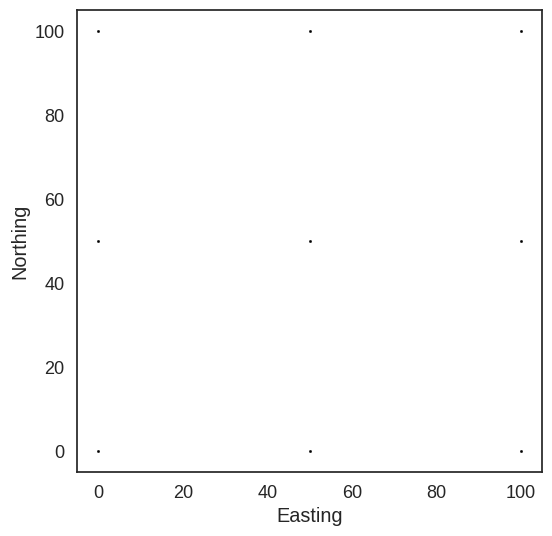

In [123]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
ax.scatter(X,Y,s=10,c='k',marker='.')

plt.xlabel("Easting")
plt.ylabel("Northing")

In [124]:
lst_soils = []
for l in range(num_layers+1):
    for k in range(len(model['xi'][l].ravel())):
            lst_soils.append({'X':model['xi'][l].ravel()[k], 'Y':model['yj'][l].ravel()[k], 'Z':model['depths'][l].ravel()[k], 'formation':model['formation'][l]})

In [125]:
soils_df = pd.DataFrame.from_dict(data=lst_soils)

In [126]:
soils_df

,X,Y,Z,formation
0,0.00,0.00,-0.27,soil1
1,50.00,0.00,-0.32,soil1
2,100.00,0.00,-0.43,soil1
3,0.00,50.00,-0.41,soil1
4,50.00,50.00,-0.37,soil1
5,100.00,50.00,-0.20,soil1
6,0.00,100.00,-0.39,soil1
7,50.00,100.00,-0.31,soil1
8,100.00,100.00,-0.47,soil1
9,0.00,0.00,-0.51,soil2


In [127]:
os.remove('data/points.csv')
soils_df.to_csv('data/points.csv', header=soils_df.columns, index=None, sep=',', mode='a')

In [128]:
lst_soils_orient = []
for l in range(num_layers+1):
    for k in range(len(model['xi'][l].ravel()[::3])):
            lst_soils_orient.append({'X':model['xi'][l].ravel()[k]*0.5, 'Y':model['yj'][l].ravel()[k]*0.5, 'Z':model['depths'][l].ravel()[k], 'formation':model['formation'][l],'Azimuth':0,'Dip':0,'Polarity':1})

soils_orient_df = pd.DataFrame.from_dict(data=lst_soils_orient)

In [129]:
soils_orient_df

,X,Y,Z,formation,Azimuth,Dip,Polarity
0,0.00,0.00,-0.27,soil1,0,0,1
1,25.00,0.00,-0.32,soil1,0,0,1
2,50.00,0.00,-0.43,soil1,0,0,1
3,0.00,0.00,-0.51,soil2,0,0,1
4,25.00,0.00,-0.69,soil2,0,0,1
5,50.00,0.00,-0.74,soil2,0,0,1
6,0.00,0.00,-1.17,soil3,0,0,1
7,25.00,0.00,-1.18,soil3,0,0,1
8,50.00,0.00,-1.03,soil3,0,0,1
9,0.00,0.00,-1.59,rock,0,0,1


In [130]:
os.remove('data/orientations.csv')
soils_orient_df.to_csv('data/orientations.csv', header=soils_orient_df.columns, index=None, sep=',', mode='a')


In [131]:
density_grid = np.concatenate(model['densities'])

depth_grid = np.concatenate(model['depths'])

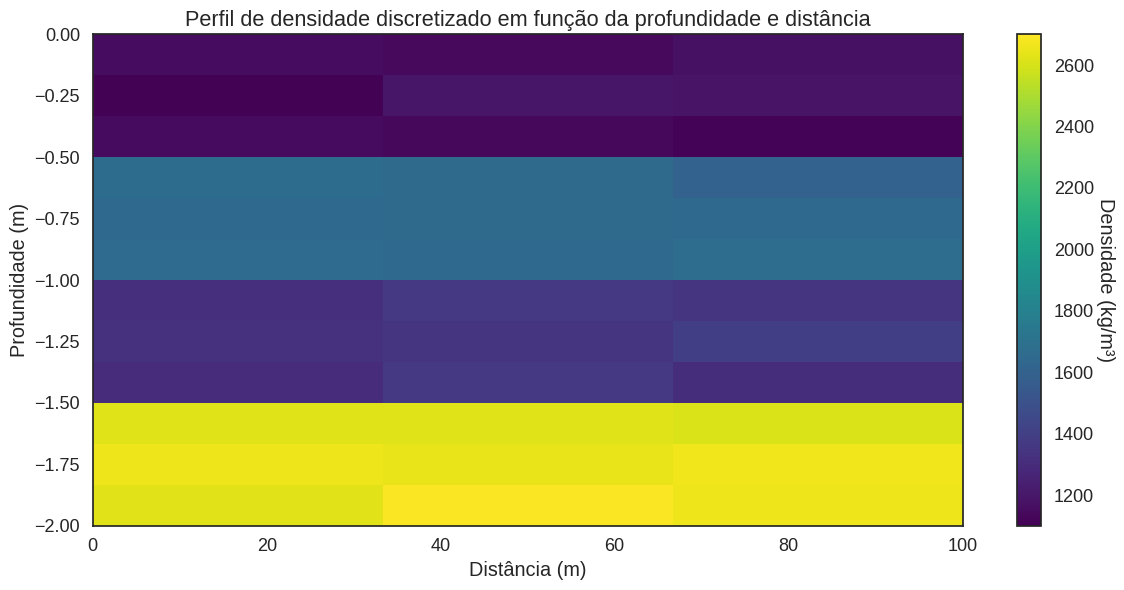

In [132]:
# Plotar o perfil de densidade ajustado
fig, ax = plt.subplots(figsize=(12, 6))
cmap = plt.get_cmap("viridis")
norm = mcolors.Normalize(vmin=1100, vmax=2700)
extent = [0, 100, -2, 0]
cax = ax.imshow(density_grid, extent=extent, origin='upper', cmap=cmap, aspect='auto', norm=norm)

# Adicionar barra de cores
cbar = fig.colorbar(cax)
cbar.set_label('Densidade (kg/m³)', rotation=270, labelpad=15)

# Configurações do gráfico
ax.set_xlabel('Distância (m)')
ax.set_ylabel('Profundidade (m)')
ax.set_title('Perfil de densidade discretizado em função da profundidade e distância')

# Ajustar layout e salvar o gráfico
plt.tight_layout()
plt.savefig('perfil_densidade_discretizado.png', dpi=300)
plt.show()

In [133]:
# Create a GeoModel instance

grid_reso = 100
# Dados do modelo
extent = [0, 100, 0, 100, -2,0]  # [x_min, x_max, y_min, y_max, z_min, z_max]
resolution = [grid_reso,grid_reso,int(grid_reso/2)]  # Resolução do grid


data = gp.create_geomodel(
    project_name='soil_horizontal',
    extent=extent,
    resolution=resolution,
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations=data_path + "/orientations.csv",
        path_to_surface_points=data_path + "/points.csv"
    )
)


In [134]:
# Compute the geological mode
gp.compute_model(data)
geo_data = data

Setting Backend To: AvailableBackends.numpy
Chunking done: 72 chunks


In [135]:
# Define structural groups and age/stratigraphic relationship
gp.map_stack_to_surfaces(
    gempy_model=geo_data,
    mapping_object={
        "Strat_Series1": ("soil3","soil2","soil1","rock")
    }
)

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Strat_Series1,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=soil3,
	color=#728f02,
	is_active=True
),
Element(
	name=soil2,
	color=#ffbe00,
	is_active=True
),
Element(
	name=soil1,
	color=#9f0052,
	is_active=True
),
Element(
	name=rock,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

In [136]:
gp.compute_model(geo_data)

Setting Backend To: AvailableBackends.numpy
Chunking done: 72 chunks


Solutions(4 Octree Levels, 4 DualContouringMeshes)

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


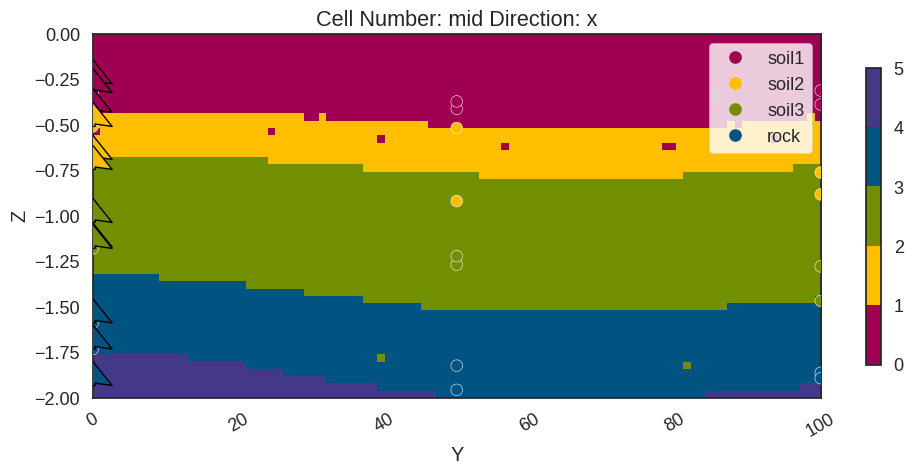

In [137]:
# Plot the result of the model in the x and y direction with data and without boundaries
gpv.plot_2d(geo_data, direction=['x'],ve=25, show_data=True, show_boundaries=True)

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


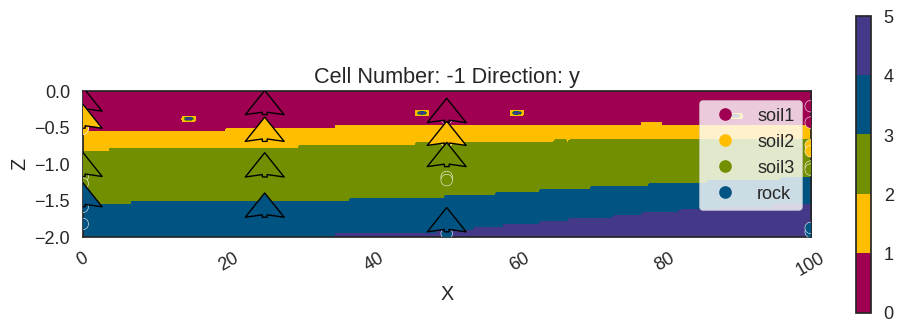

In [138]:
gpv.plot_2d(geo_data, cell_number=[-1], direction=['y'],ve=10, show=True,kwargs_regular_grid={'alpha': .5})

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


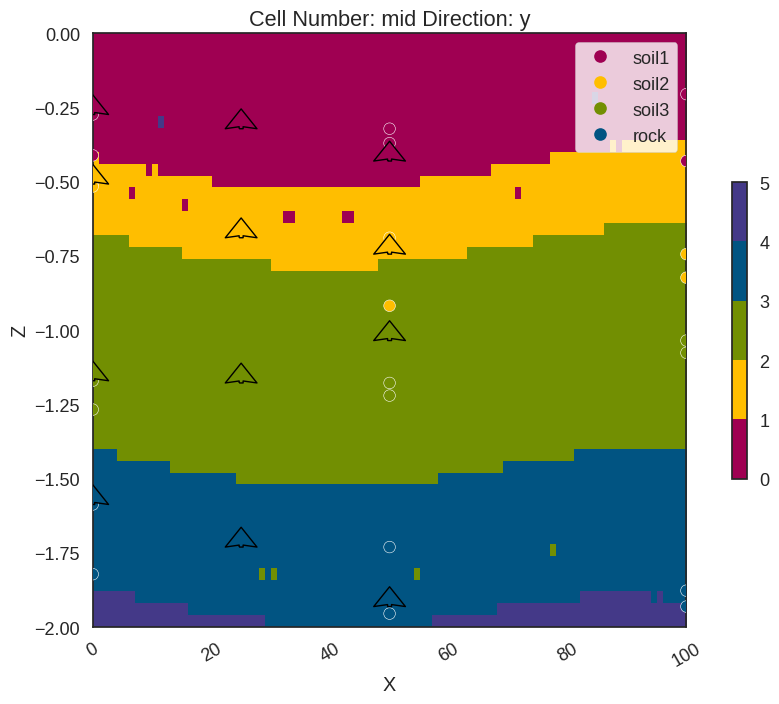

In [139]:
gpv.plot_2d(geo_data, direction=['y'],ve=50, show_data=True, show_boundaries=True)

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


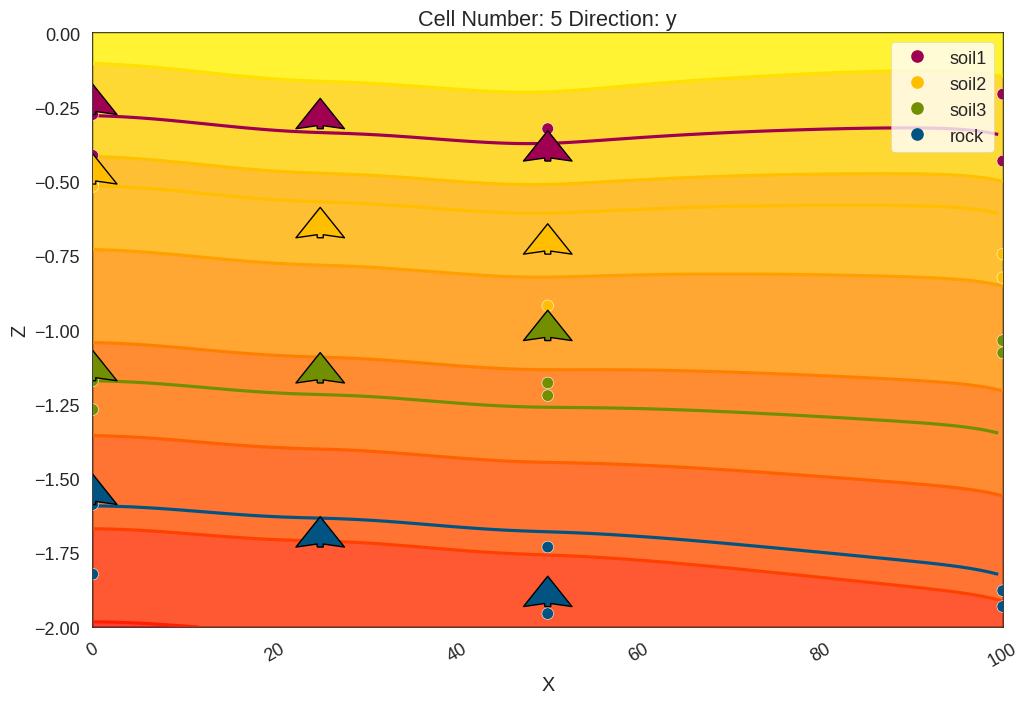

In [140]:
gpv.plot_2d(geo_data, show_value=True, show_lith=False, show_scalar=True, cell_number=5)


In [141]:
gpv.plot_3d(geo_data,ve=10, show_scalar=False)

In [142]:
gempy_plot = gpv.plot_3d(
    model=geo_data,
    show_scalar=False,
    ve=10,
    show=False,
    image=False,
    transformed_data=False,
    kwargs_pyvista_bounds={
            'show_xlabels': False,
            'show_ylabels': False,
            'show_zlabels': True,
            'show_xaxis': False,
            'show_yaxis': False,
    },
    kwargs_plot_data={
            'arrow_size': 40.0
    }
)



gempy_plot.p.show()

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


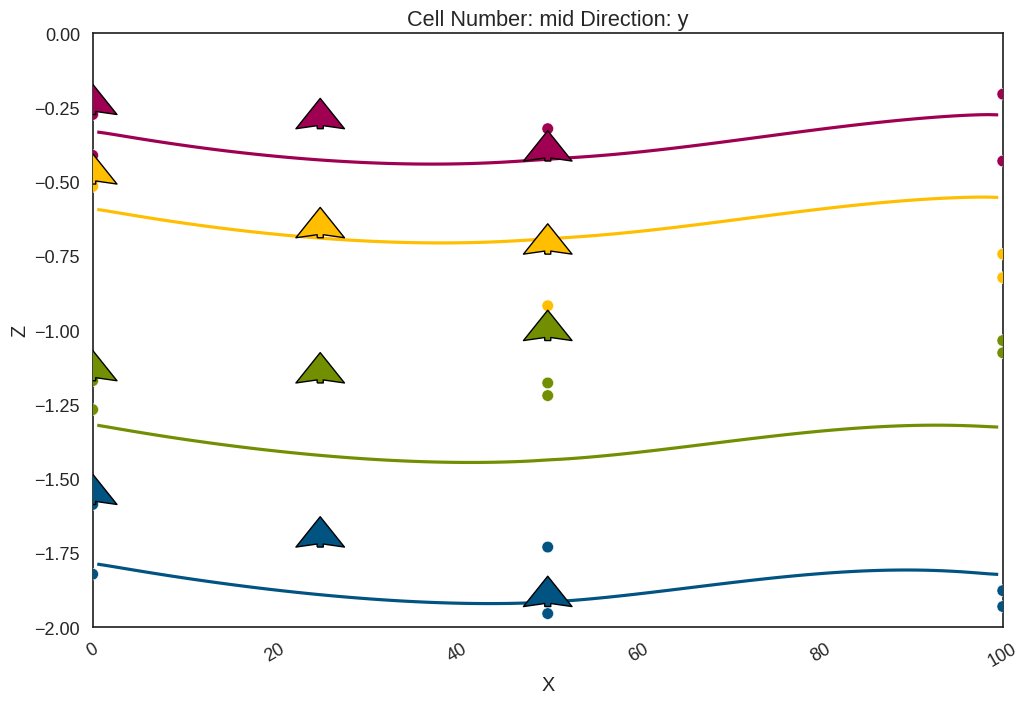

In [143]:
gpv.plot_2d(geo_data, show_value=False, show_lith=False, show_scalar=False,legend=False, cell_number='mid')

In [144]:
lith_block = geo_data.solutions.raw_arrays.lith_block.reshape(grid_reso,grid_reso,int(grid_reso/2))
lith_block.shape

(100, 100, 50)

In [145]:
np.unique(geo_data.solutions.raw_arrays.lith_block)

array([1, 2, 3, 4, 5, 6], dtype=int8)

In [161]:
density_values = [np.mean(i) for i in model['densities']]

In [162]:
density_dict = {k: v for k,v in zip(np.unique(np.round(lith_block)), density_values)}
density_dict

{1: 1149.6079639277855,
 2: 1649.8372959611315,
 3: 1343.4148191290255,
 4: 2645.238382623467,
 5: 2700.0}

In [163]:
density_block = gg.utils.assign_properties(lith_block=lith_block, property_dict=density_dict)

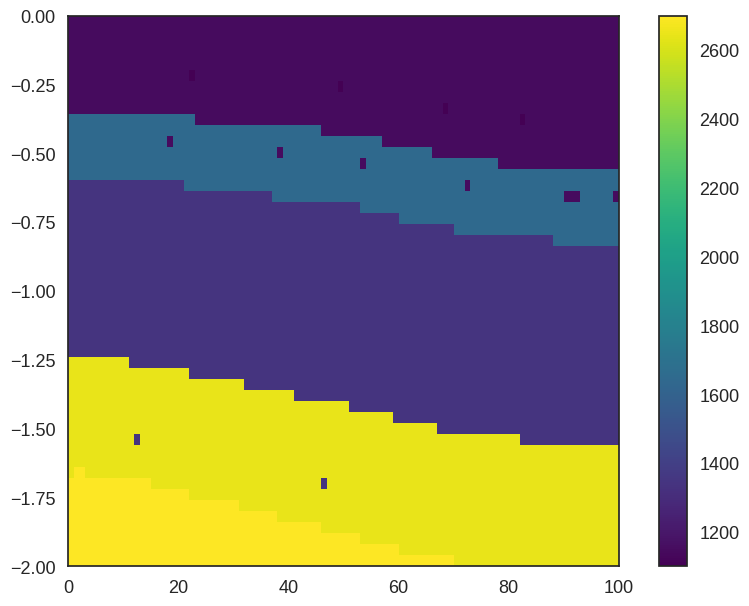

In [164]:
im = plt.imshow(density_block[3,:,:].T, cmap='viridis',extent=[0, 100, -2.0, 0],vmin=1100.0,vmax=2700.0,aspect=50,origin='lower')

plt.colorbar(im);

In [165]:
np.save('data/density_block.npy', density_block)

In [166]:
volume = pv.wrap(density_block)

In [167]:
volume.save('data/density_block.vtk',binary=True)

# DISBA - surface wave dispersion

In [168]:
density_block.shape

(100, 100, 50)

In [169]:
north/grid_reso

1.0

In [170]:
lst_receptor = np.arange(1, density_block.shape[0]-1,10)

In [171]:
lst_receptor

array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])

In [172]:
line_row = np.random.randint(low=0,high=density_block.shape[0]-1)
line_row

51

In [173]:
slice_block = density_block[line_row,:,::].T

In [174]:
slice_block

array([[2700.        , 2700.        , 2700.        , ..., 2700.        ,
        2700.        , 2700.        ],
       [2700.        , 2700.        , 2700.        , ..., 2700.        ,
        2700.        , 2700.        ],
       [2700.        , 2700.        , 2700.        , ..., 2645.23838262,
        2645.23838262, 2645.23838262],
       ...,
       [1149.60796393, 1149.60796393, 1149.60796393, ..., 1149.60796393,
        1149.60796393, 1149.60796393],
       [1149.60796393, 1149.60796393, 1149.60796393, ..., 1149.60796393,
        1149.60796393, 1149.60796393],
       [1149.60796393, 1149.60796393, 1149.60796393, ..., 1149.60796393,
        1149.60796393, 1149.60796393]])

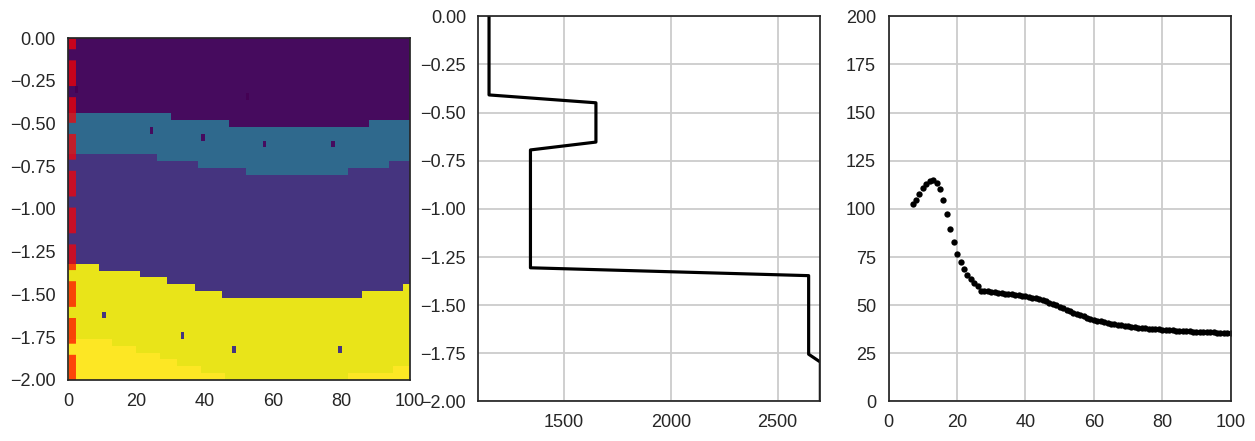

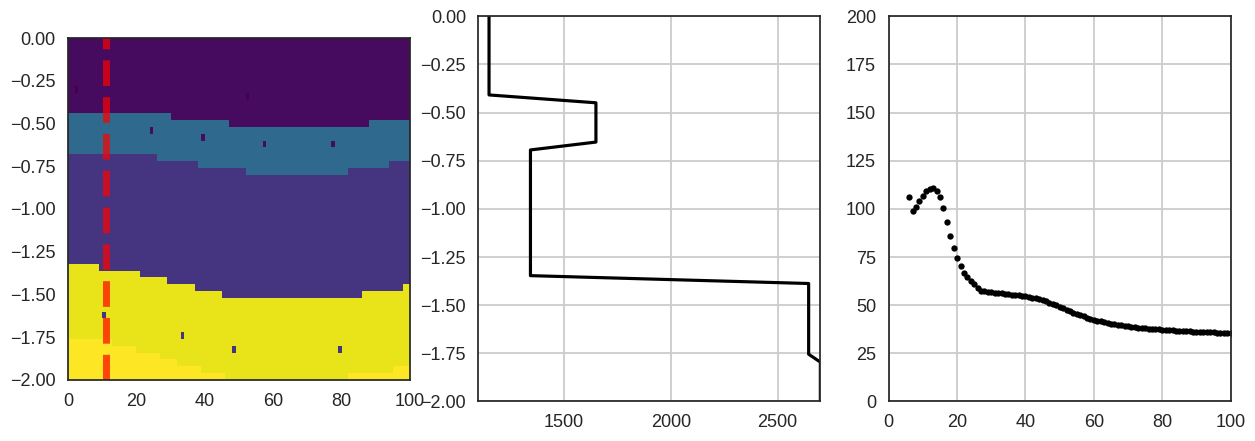

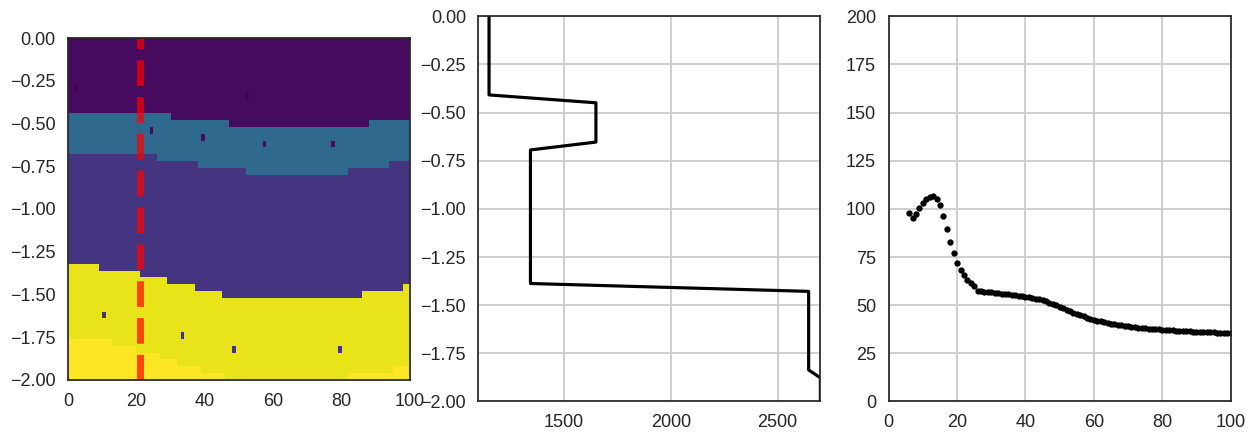

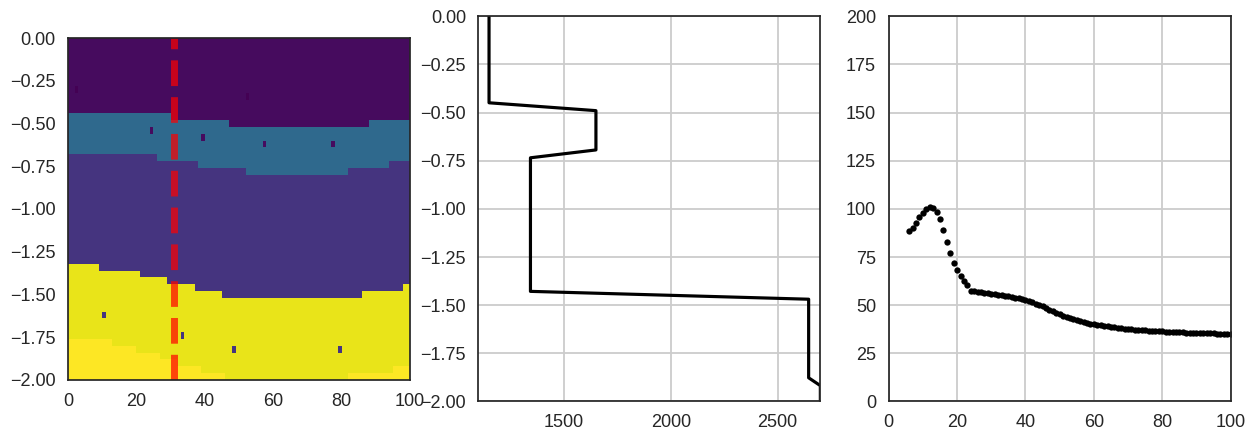

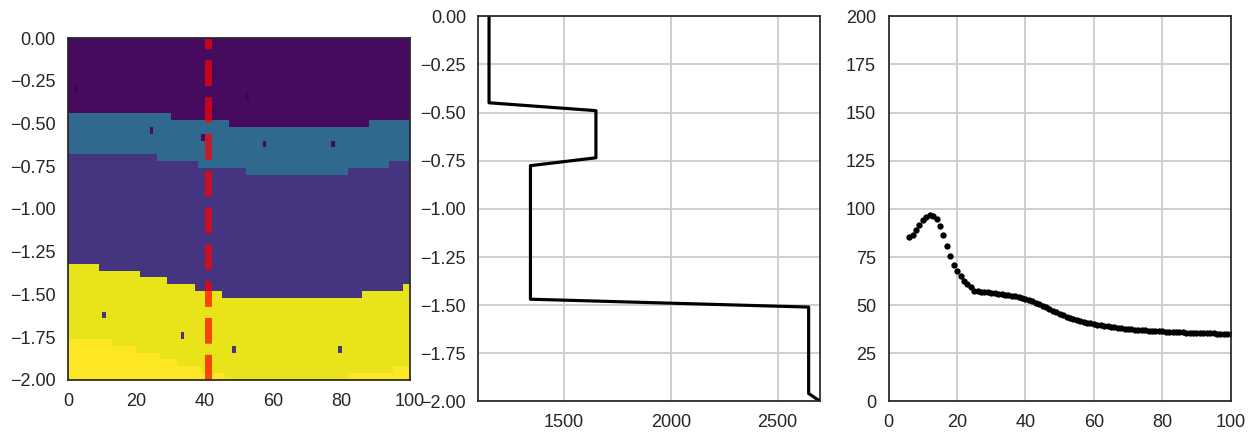

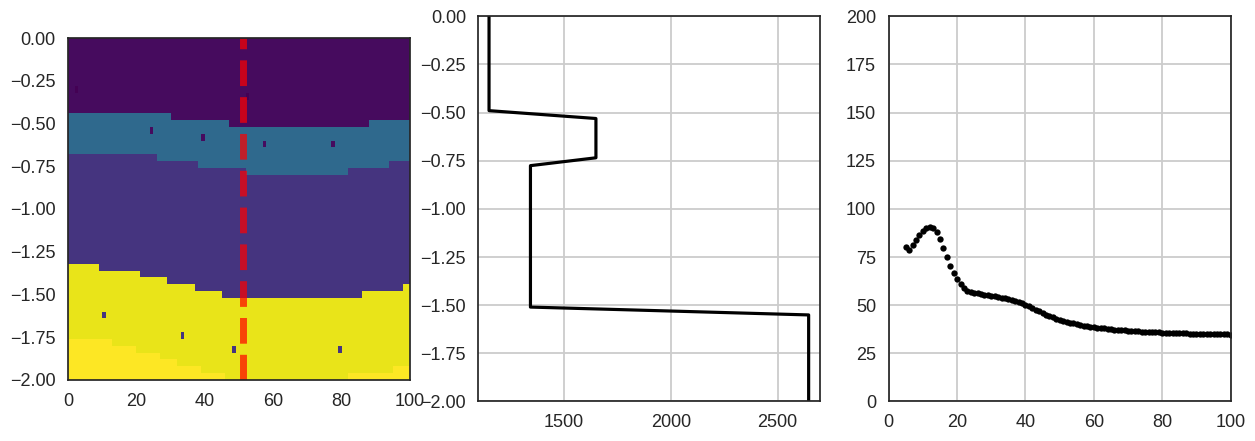

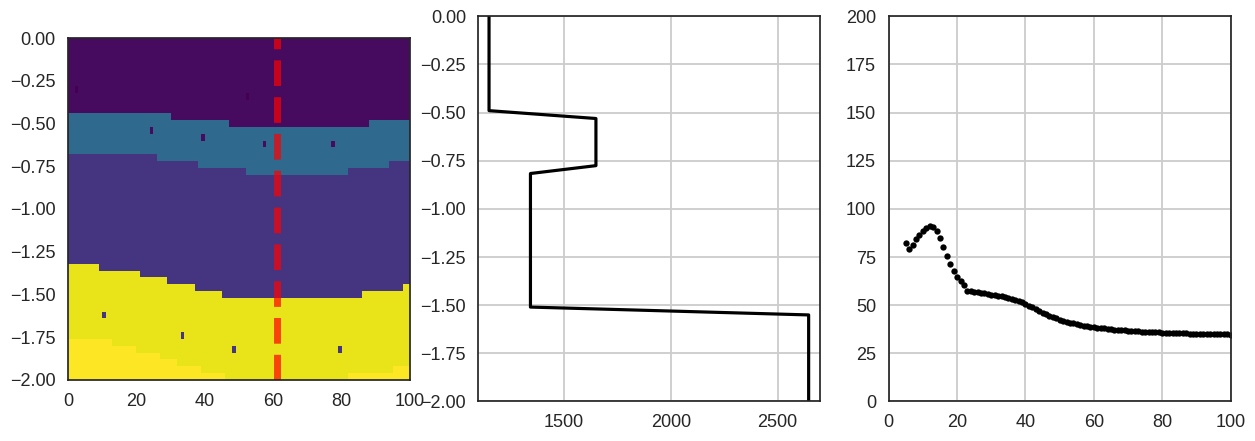

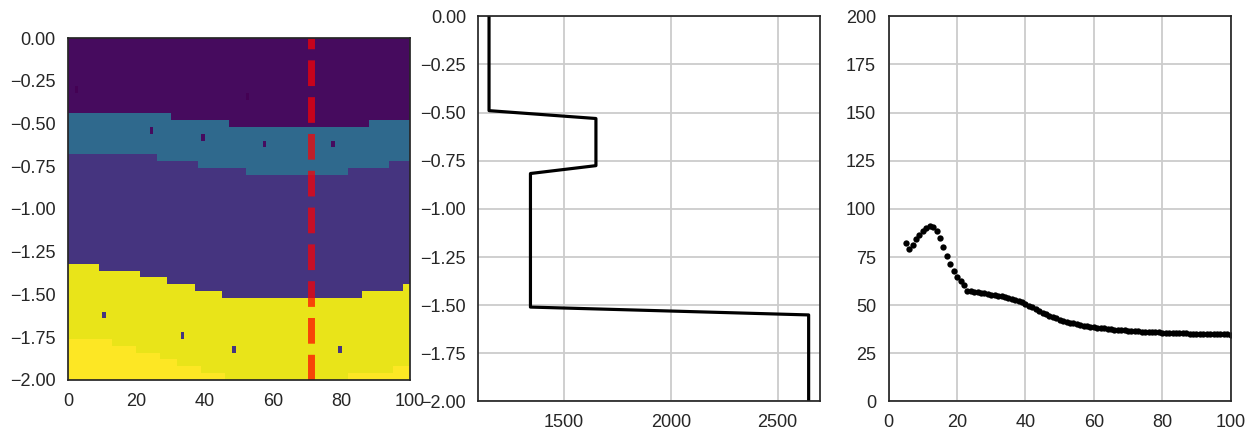

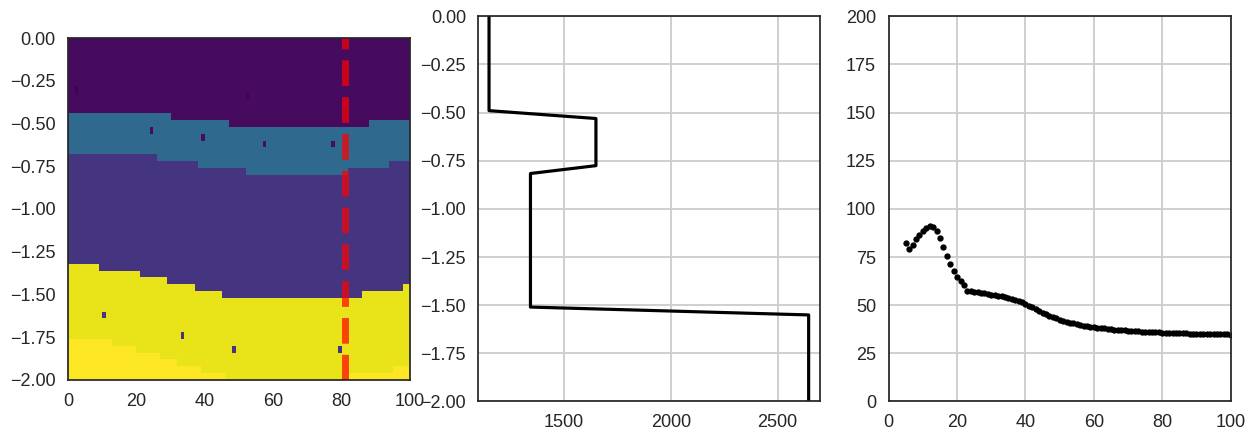

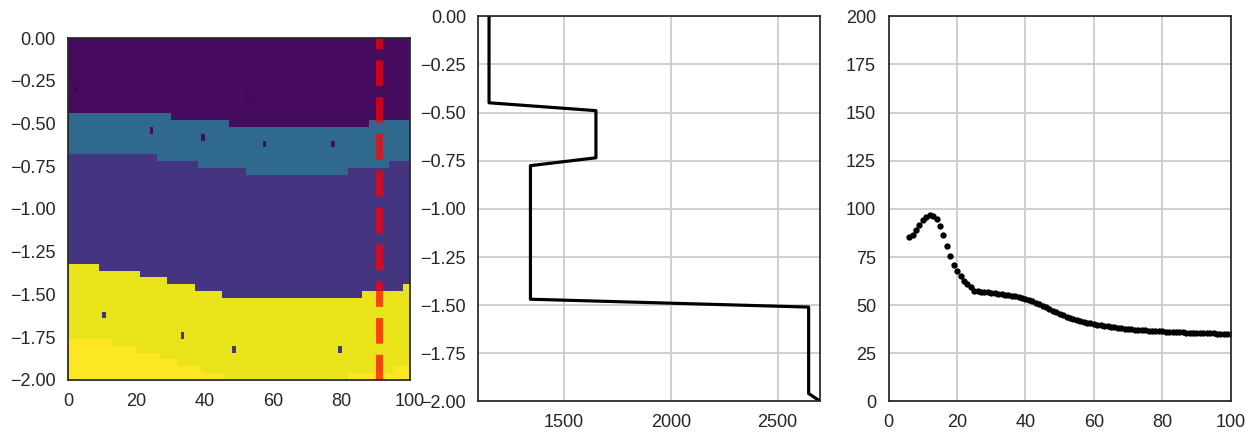

In [175]:
profile_lst = []
dispersion_curve_lst = []

profile_number = np.random.random(size=1)

for ix in lst_receptor:
    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))

    im = ax.imshow(slice_block, cmap='viridis',extent=[0, 100, -2.0, 0],vmin=1100.0,vmax=2700.0,aspect=50,origin='lower')
    ax.vlines(x=ix*(north/grid_reso),ymin=-2.0,ymax=0,colors='r',lw=5.0,ls='--',alpha=0.7)

    profile_lst.append(slice_block[:,ix])
    ax1.plot(slice_block[:,ix],np.linspace(-2., 0,len(slice_block[:,ix])),'-k')
    ax1.set_xlim(1100.0,2700.0)
    ax1.set_ylim(-2.0,0.0)
    ax1.grid('on')
         
    velocity_model =create_velocity_model_from_profile(model_profile=slice_block[:,ix])    

    cpr = estimate_disp_from_velocity_model(velocity_model)  

    dispersion_curve_lst.append(cpr.velocity*1000)
    ax2.plot(1/cpr.period,cpr.velocity*1000,'.k')
    ax2.grid('on')
    ax2.set_ylim(0,200)
    ax2.set_xlim(0,100)


In [176]:
filename_npy = 'data/density_block.npy'

data_grid = np.load(filename_npy)

In [177]:
data_grid.shape

(100, 100, 50)

In [178]:
len(profile_lst)

10

In [179]:
# Variáveis globais para armazenar os valores da função objetivo por iteração
objective_values = []

# Função objetivo para a inversão usando DEAP
def inversion_objective(individual, true_disp):

    # Simula a curva de dispersão com base nas velocidades estimadas de Vs (indivíduo) para otimização
    simulated_velocity_model = create_velocity_model_from_profile_vs(individual)

    simulated_cpr = estimate_disp_from_velocity_model(simulated_velocity_model)

    simulated_dispersion = simulated_cpr.velocity*1000
    
    # Calcula o erro como a soma dos quadrados das diferenças entre a curva simulada e a curva estimada
    error = np.sum((simulated_dispersion - true_disp) ** 2)

    # Armazenar o valor da função objetivo
    objective_values.append(error)
    
    return error,

# Configuração da DEAP para otimização evolutiva
def configure_deap(estimated_disp):
    if "FitnessMin" in creator.__dict__:
        del creator.FitnessMin
    if "Individual" in creator.__dict__:
        del creator.Individual

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    
    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.random_integers, 25, 200)  # Intervalo de velocidades S (Vs)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(estimated_disp))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", inversion_objective, true_disp=estimated_disp)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    return toolbox

# Função principal para rodar a inversão
def run_inversion():
    # Carregar as velocidades estimadas 
    estimated_disp = dispersion_curve_lst[0]

    # Configurar DEAP
    toolbox = configure_deap(estimated_disp)

    # Realizar a evolução (inversão) usando algoritmo genético
    population = toolbox.population(n=50)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=True)

    # Extrair o melhor indivíduo após a evolução
    best_individual = tools.selBest(population, k=1)[0]

    # Salvar o melhor indivíduo (velocidades invertidas) no arquivo 'vs_inverted.pkl'
    with open('vs_inverted.pkl', 'wb') as f:
        pickle.dump({'velocities': best_individual, 'depths': depths}, f)

    # Plotar resultados
    plot_inverted_vs_profile(best_individual, depths)
    plot_convergence()

# Função para plotar o perfil invertido de Vs
def plot_inverted_vs_profile(velocities, depths):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.step(velocities, depths, where='post', color='b', linewidth=2, label=f'Modelo final após {len(objective_values)} iterações')
    ax.set_title('Perfil de velocidade Vs em função da profundidade (Evolutionary Algorithms)')
    ax.set_xlabel('Velocidade da onda S (m/s)')
    ax.set_ylabel('Profundidade (m)')
    ax.invert_yaxis()  # Inverter eixo Y para profundidade aumentar para baixo
    ax.grid(True)
    plt.tight_layout()
    ax.minorticks_on()
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

    plt.savefig('perfil_vs_invertido.png', dpi=300)
    plt.show()

# Função para plotar a convergência da função objetivo
def plot_convergence():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(objective_values, label='Função objetivo por iteração', color='blue')
    ax.set_title('Convergência da função objetivo')
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Valor da função objetivo')
    ax.axvline(x=len(objective_values)-1, color='red', linestyle='--', label='Última iteração')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    ax.minorticks_on()
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

    plt.savefig('convergencia_funcao_objetivo.png', dpi=300)
    plt.show()

# Executar o processo de inversão
if __name__ == "__main__":
    run_inversion()

DispersionError: failed to find root for fundamental mode